In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

In [103]:
import pandas as pd
import seaborn as sns

#from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline

## Cargamos la data 

El dataset Fashion-MNIST cotiene 60,00 imagenes para el set de datos de entrenamiento y un set de datos de prueba de 10,000.

In [104]:
fashion_mnist = keras.datasets.fashion_mnist

In [105]:
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

## Imagenes
Las imagenes son Numpy Arrays de 28x28, los pixeles estan entre los valores de 0 a 255

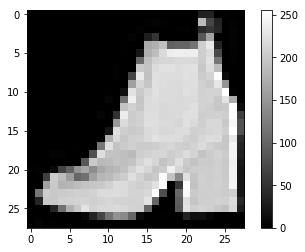

In [106]:
plt.imshow(train_images[800], cmap = 'gray')
plt.colorbar()

## Labels

In [107]:
np.unique(train_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

| Label | Class       |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

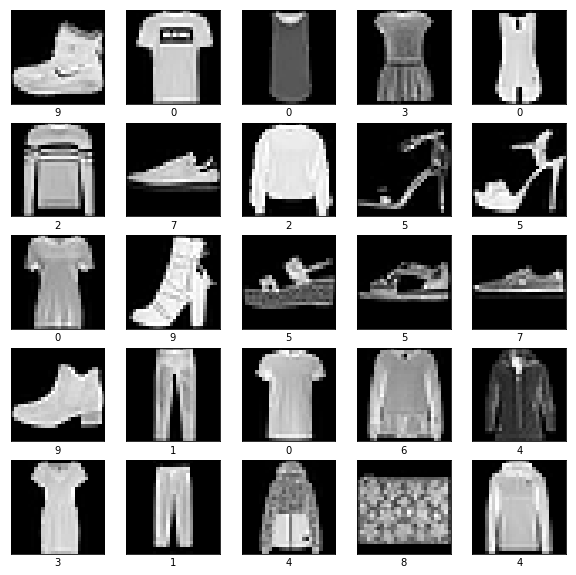

In [108]:
plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap='gray')
    plt.xlabel(train_labels[i])
plt.show()

# Tarea

Para esta tarea se deben utilizar únicamente 3 clases, se puede escoger cualquiera de las 10 disponibles en el data set, por lo que hay que filtrar las clases elegidas en los arreglos:
- train_images
- train_labels
- test_images
- test_labels

El objetivo de la tarea es comparar la diferencia al aplicar feature scale/normalization y las features sin ninguna transformación y comparar el efecto de el scaling/normalización sobre el entrenamiento con regresión logística.
- Se debe crear un diccionario con el valor numérico de las labels y el texto correspondiente para poder relacionar el valor numérico con el valor descriptivo/textual.
- Aplicar regresión logística con entropía cruzada como función de costo, crear una función que recibe de entrada un tensor x y predice la clase(utilizar el diccionario para mostrar el texto perteneciente al label).
- Adicional a el costo(por entropía cruzada) en el grafo se debe agregar un nodo que calcule el acurracy(comparando el valor real vs el estimado por el modelo).
- El accuracy y el costo deben ser agregados a tensorboard(agregar screenshots al notebook)
- Se debe agregar al notebook un screenshot del grafo/grafos de tensorboard, simplificando(usando names y name_scope como visto en clase).
- Todo lo anterior se debe hacer tanto para datos crudos, como para datos transformados con (normalización y escalado)
- Basado en los ejemplos de visualización de imagenes en el notebook ,crear una función que reciba de entrada el tensor que representa a una imagen, grafique esta imagen poniendo como título el nombre de la prenda con mayor probabilidad.
- Utilizar la función anterior para mostrar una muestra aleatoria de 5 imágenes(y la predicción probabilistica de la prenda)
- Comparar con tensorboard las curvas de aprendizaje del entrenamiento con datos crudos vs datos transformados, y los 2 grafos y concluir/opinar al respecto usando markdown(agregando screenshots)
- Utilizar mini batch gradient descent con batch size de 32

In [109]:
Filtro_train=(train_labels==0)|(train_labels==1)|(train_labels==2)
Filtro_test=(test_labels==0)|(test_labels==1)|(test_labels==2)

In [110]:
x_train = train_images[Filtro_train]
y_train = train_labels[Filtro_train]
x_test = test_images[Filtro_test]
y_test = test_labels[Filtro_test]

In [111]:
print("test_images ",len(x_test))
print("test_labels ",len(y_test))

print("train_images ",len(x_train))
print("train_labels ",len(y_train))

test_images  3000
test_labels  3000
train_images  18000
train_labels  18000


### Diccionario

In [112]:
diccionario={0:"T-shirt/top",1:"Trouser",2:"Pullover"}

### Pre-Procesamiento

In [113]:
##Normalización
x_train = x_train/255
x_test = x_test/255

print(x_train.shape)
print(x_test.shape)

(18000, 28, 28)
(3000, 28, 28)


In [114]:
#Darle la nueva forma
x_train = x_train.reshape(18000, 28 * 28)
x_test = x_test.reshape(3000, 28 * 28)

In [115]:
##One-Hot
with tf.Session() as sesh:
    y_train = sesh.run(tf.one_hot(y_train, 3))
    y_test = sesh.run(tf.one_hot(y_test, 3))

### Hiperparametros

In [116]:
learning_rate = 0.01
epochs = 100
batch_size = 32
display_step = 5
batches = int(x_train.shape[0] / batch_size)

### inputs (x, y), weights (w) & bias (b)

In [117]:
with tf.name_scope("declaracion_placeholder"):
        # x es el placeholder que alimentará la data de imagenes
    X = tf.placeholder(tf.float32, [None, 784])
        # y es el placeholder que alimentara la data de label
    Y = tf.placeholder(tf.float32, [None, 3])
    
with tf.name_scope("declaracion_variables"):
        # W son los pesos de entrenamiento
    W = tf.Variable(tf.zeros([784, 3]))
        # b son nuestras desviaciones para el entrenamiento
    b = tf.Variable(tf.zeros([3]))

$\mathbf{Y}=\sigma(\mathbf{X}\cdot\mathbf{W} + \mathbf{B})$

$ 
\begin{pmatrix}
    y_1 \\ y_2 \\ \vdots \\ y_{10}
\end{pmatrix}=\sigma\left[
\begin{pmatrix}
    x_1 & x_2 & \dots & x_{784}
\end{pmatrix}
\begin{pmatrix}
    w_{1, 1} & w_{1, 2}  & \dots  & w_{1, 10} \\
    w_{2, 1} & w_{2, 2}  & \dots  & w_{2, 10} \\
    \vdots &  \vdots & \ddots & \vdots \\
    w_{784, 1} & w_{784, 2}  & \dots  & w_{784, 10}
\end{pmatrix} +
\begin{pmatrix}
    b_1 \\ b_2 \\ \vdots \\ b_{10}
\end{pmatrix}
\right]
$

### Funcion de Costo

In [118]:
with tf.name_scope("declaracion_funciones"):
        # Funcion de predicción
    predic = tf.nn.softmax(tf.add(tf.matmul(X, W), b))

with tf.name_scope("calculating_cost"):
        # calculo de costo
    costo = tf.nn.softmax_cross_entropy_with_logits(labels=Y, logits=predic)

with tf.name_scope("declaring_gradient_descent"):
        # Optimizador con gradient descent
    optimizador = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(costo)   

$
C = \sum -Y\ln(predic)
$

### Sesion de Tensorflow para Entrenamiento

Epoch: 5 cost=[0.55144465 0.55144465 0.55144465 ... 0.5514447  0.55144465 1.5514427 ]
Epoch: 10 cost=[0.55144465 0.55144465 0.55144465 ... 0.5514447  0.55144465 0.5547305 ]
Epoch: 15 cost=[0.55144465 0.55144465 0.55144465 ... 0.5514447  0.55144465 0.55144465]
Epoch: 20 cost=[0.55144465 0.55144465 0.55144465 ... 0.5514447  0.55144465 0.55144465]
Epoch: 25 cost=[0.55144465 0.55144465 0.55144465 ... 0.5514447  0.55144465 0.55144465]
Epoch: 30 cost=[0.55144465 0.55144465 0.55144465 ... 0.5514447  0.55144465 0.55144465]
Epoch: 35 cost=[0.55144465 0.55144465 0.55144465 ... 0.5514447  0.55144465 0.55144465]
Epoch: 40 cost=[0.55144465 0.55144525 0.55144465 ... 0.5514447  0.55144465 0.55144465]
Epoch: 45 cost=[0.55144465 0.5543357  0.55144465 ... 0.5514447  0.55144465 0.55144465]
Epoch: 50 cost=[0.55144465 0.8253505  0.55144465 ... 0.5514447  0.55144465 0.55144465]
Epoch: 55 cost=[0.55144465 1.5508382  0.55144465 ... 0.5514447  0.55144465 0.55144465]
Epoch: 60 cost=[0.55144465 1.551444   0.5514

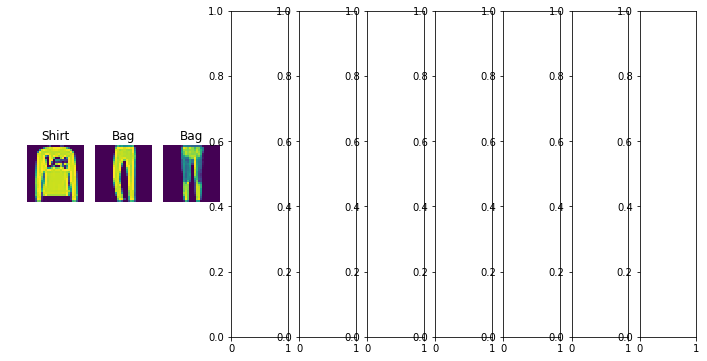

In [119]:
with tf.name_scope("starting_tensorflow_session"):
    with tf.Session() as sess:
            
            # Inicializar todas las Variables
        sess.run(tf.global_variables_initializer())
        
        for epoch in range(epochs):
            cost_in_each_epoch = 0
            
            # Inicio del Entrenamiento
            _, c = sess.run([optimizador, costo], feed_dict={X: x_train, Y: y_train})
            cost_in_each_epoch += c
            
            # Print funcion Costo en entrenamiento
            if (epoch+1) % display_step == 0:
                print("Epoch: {}".format(epoch + 1), "cost={}".format(cost_in_each_epoch))
        
        print("Optimizacion Finalizada!")

        # Modelo de Prueba
        correct_prediction = tf.equal(tf.argmax(predic, 1), tf.argmax(Y, 1))
        fig, axes = plt.subplots(1,10,figsize=(12,6))
        for img, ax in zip(x_test[:3],axes):
            #guess=np.argmax(sess.run(predic,feed_dict={X:[img]}))
            guess=diccionario[np.argmax(sess.run(predic,feed_dict={X:[img]}))]
            ax.set_title(guess)
            ax.imshow(img.reshape((28,28)))
            ax.axis('off')

### Otra sesion de prueba.

In [124]:
with tf.Session() as sesh:
    sesh.run(tf.global_variables_initializer())
    
    for epoch in range(epochs):
        for i in range(batches):
            offset = i * epoch
            x = x_train[offset: offset + batch_size]
            y = y_train[offset: offset + batch_size]
            sesh.run(optimizador, feed_dict={X:x, Y:y})
            c = sesh.run(costo, feed_dict={X:x, Y:y})
        
        #if not epochs % 2:
         #   print(f'epochs:{epochs:2d} costo={c:4f}')
            
    correct_prediction = tf.equal(tf.argmax(predic, 1), tf.argmax(Y, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    acc = accuracy.eval({X: x, Y: y})
    print(f'Accuracy: {acc * 100:.2f}%')
    
    fig, axes = plt.subplots(1, 10, figsize=(8, 4))
    for img, ax in zip(x_train[:100], axes):
        guess = np.argmax(sesh.run(predic, feed_dict={X: [img]}))
        ax.set_title(guess)
        ax.imshow(img.reshape((28, 28)))
        ax.axis('off')

KeyboardInterrupt: 